In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import heapq
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(4,)
action space: Discrete(2)


c:\users\andre\desktop\udacity drl\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
class PolicyNet():
    def __init__(self, pop_size, s_size=4, a_size=2, noise=1e-2, noise_min=1e-3, noise_max=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)
        self.noise = noise
        self.nmin = noise_min
        self.nmax = noise_max
        self.popsize = pop_size
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))#softmax(x)
    
    def act(self, state, stochastic=False):
        probs = self.forward(state)
        if stochastic == False:
            action = np.argmax(probs)
        else:
            action = np.random.choice(2, p=probs)
        return action
    
    def populate(self):
        population = np.array([self.w + self.noise*np.random.rand(*self.w.shape) for _ in range(self.popsize)])
        return population

In [4]:
def hill_climbing(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state=env.reset()
        
        for t in range(max_t):
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
                
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        if R >= best_R:
            best_R = R
            best_w = policy.w
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w += policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
            
    return scores

Episode 100	Average Score: 115.76
Episode 200	Average Score: 191.62
Episode 300	Average Score: 193.25
Episode 400	Average Score: 192.73
Episode 500	Average Score: 188.14
Episode 600	Average Score: 191.92
Episode 700	Average Score: 181.88
Episode 800	Average Score: 186.54
Episode 900	Average Score: 185.79
Episode 1000	Average Score: 188.10


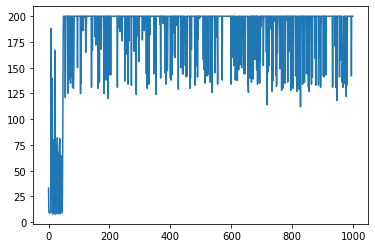

In [6]:
policy = PolicyNet(pop_size=1)
scores = hill_climbing(policy)
plt.plot(scores)

In [9]:
def steepest_hill_climbing(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = np.zeros((max_t, policy.popsize))
        policies = policy.populate()
        state_alpha = env.reset()
        
        for p in range(policy.popsize):
            policy.w = policies[p]
            state = state_alpha
            
            for t in range(max_t):
                action = policy.act(state)
                state, reward, done, _ = env.step(action)
                rewards[t,p] = reward
                if done:
                    break
        
        discounts = np.array([gamma**i for i in range(1000)])
        returns = np.sum(np.array([a*b for a,b in zip(rewards, discounts)]), axis = 0)
                
        best_p = np.argmax(returns)
        if returns[best_p] >= best_R:
            best_R = returns[best_p]
            best_w = policies[best_p]
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
                
        scores_deque.append(np.sum(rewards[:,best_p]))
        scores.append(np.sum(rewards[:,best_p]))
        
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
            
    return scores

In [10]:
policy = PolicyNet(pop_size=50)
scores_steepest = steepest_hill_climbing(policy)

Episode 100	Average Score: 111.57
Environment solved in 150 episodes!	Average Score: 196.42


array([[4.03391198, 4.28917409],
       [4.46150503, 5.51902406],
       [4.89189485, 5.86428271],
       [2.54878628, 4.14768754]])

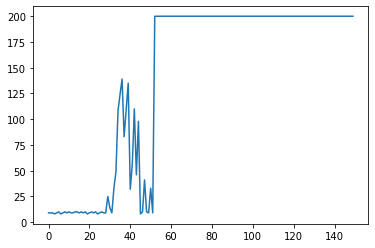

In [11]:
plt.plot(scores_steepest)
policy.w

In [ ]:
from IPython import display
torender_episodes = 3
torender_frames = 100

plt.figure(figsize=(9,9))

for i in range(0,torender_episodes):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(torender_frames):
        action = policy.act(state)
        img.set_data(env.render(mode='rgb_array'))
        plt.axis('off')
        plt.text(50,50,j)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        plt.text(50,50.'')
        if done:
            break 

env.close()

In [13]:
def steepest_hill_climbing_topk(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, topk=10):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = np.zeros((max_t, policy.popsize))
        policies = policy.populate()
        state_alpha = env.reset()
        
        for p in range(policy.popsize):
            policy.w = policies[p]
            state = state_alpha
            
            for t in range(max_t):
                action = policy.act(state)
                state, reward, done, _ = env.step(action)
                rewards[t,p] = reward
                if done:
                    break
        
        discounts = np.array([gamma**i for i in range(1000)])
        returns = np.sum(np.array([a*b for a,b in zip(rewards, discounts)]), axis = 0)
                
        best_p = np.argmax(returns)
        
        top_k = heapq.nlargest( topk , range(len(returns)), returns.__getitem__)
        
        if returns[best_p] >= best_R:
            best_R = returns[best_p]
            best_w = np.mean(policies[top_k],axis=0)
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
                
        scores_deque.append(np.sum(rewards[:,best_p]))
        scores.append(np.sum(rewards[:,best_p]))
        
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
            
    return scores

In [14]:
policy = PolicyNet(pop_size=100)
scores_steepest = steepest_hill_climbing_topk(policy, topk=10)

c:\users\andre\desktop\udacity drl\gym\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100	Average Score: 117.41
Environment solved in 157 episodes!	Average Score: 195.95


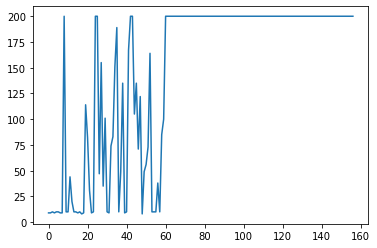

In [15]:
plt.plot(scores_steepest)

In [19]:
scores_stochastic = []
scores_steepest = []
scores_evo = []

for i in range(10):
    policy_stochastic = PolicyNet(pop_size=1)
    scores_stochastic.append(hill_climbing(policy_stochastic));
    
    policy_steepest = PolicyNet(pop_size=50)
    scores_steepest.append(steepest_hill_climbing(policy_steepest));
    
    policy_steepest_evo = PolicyNet(pop_size=50)
    scores_evo.append(steepest_hill_climbing_topk(policy_steepest_evo,topk=10));

Episode 100	Average Score: 160.42
Environment solved in 126 episodes!	Average Score: 195.51


c:\users\andre\desktop\udacity drl\gym\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100	Average Score: 175.14
Environment solved in 117 episodes!	Average Score: 196.48
Episode 100	Average Score: 164.01
Environment solved in 123 episodes!	Average Score: 196.19
Episode 100	Average Score: 137.07
Environment solved in 177 episodes!	Average Score: 196.20
Episode 100	Average Score: 167.44
Environment solved in 118 episodes!	Average Score: 196.51
Episode 100	Average Score: 78.93
Environment solved in 176 episodes!	Average Score: 196.19
Episode 100	Average Score: 126.15
Environment solved in 150 episodes!	Average Score: 196.45
Episode 100	Average Score: 112.58
Environment solved in 162 episodes!	Average Score: 196.59
Episode 100	Average Score: 161.71
Environment solved in 123 episodes!	Average Score: 195.68
Episode 100	Average Score: 140.14
Episode 200	Average Score: 179.86
Episode 300	Average Score: 176.62
Episode 400	Average Score: 173.09
Episode 500	Average Score: 179.93
Episode 600	Average Score: 174.92
Episode 700	Average Score: 177.55
Episode 800	Average Score: 

Stochastic: 3227
Steepest: 998
Evo: 3195


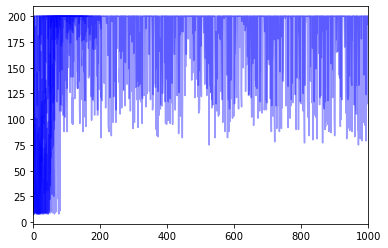

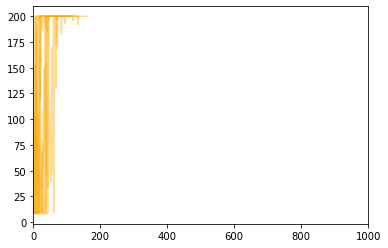

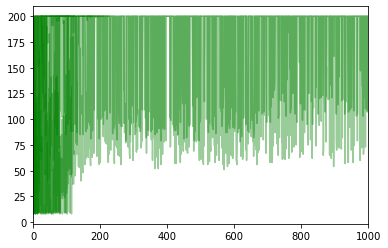

In [22]:
l = 0
for s in scores_stochastic:
    plt.plot(s, c='b', alpha = 0.4)
    l+=len(s)
plt.xlim(xmin=0, xmax=1000)
print('Stochastic: {}'.format(l))
l = 0
plt.figure()

for s in scores_steepest:
    plt.plot(s, c='orange', alpha = 0.4)
    l+=len(s)
plt.xlim(xmin=0, xmax=1000)
print('Steepest: {}'.format(l))
l = 0

plt.figure()
for s in scores_evo:
    plt.plot(s, c='green', alpha = 0.4)
    l+=len(s)
plt.xlim(xmin=0, xmax=1000)
print('Evo: {}'.format(l))
l = 0

In [25]:
for g in scores_steepest:
    print(len(g))

117
118
162
1
1
138
134
104
115
108
